In [62]:
import pandas as pd
from datetime import datetime

# Define the column names as provided
column_names = ['date', 'time', 'epoch', 'moteid', 'temperature', 'humidity', 'light', 'voltage']

# Load the data with proper column names
df = pd.read_csv('data/data.txt', sep=' ', header=None, names=column_names)

# Function to parse the time with fallback for different formats
def parse_time(time_str):
    try:
        return datetime.strptime(time_str, '%H:%M:%S.%f').time()
    except ValueError:
        try:
            return datetime.strptime(time_str, '%H:%M:%S').time()
        except ValueError:
            return None

# Apply the function to the 'time' column
df['time'] = df['time'].apply(parse_time)

# Ensure the 'date' column is parsed correctly
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce').dt.date

# Ensure correct data types for other columns
df['epoch'] = pd.to_numeric(df['epoch'], errors='coerce').astype('Int64')
df['moteid'] = pd.to_numeric(df['moteid'], errors='coerce').astype('Int64')
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
df['light'] = pd.to_numeric(df['light'], errors='coerce')
df['voltage'] = pd.to_numeric(df['voltage'], errors='coerce')

# Print the last few rows of the dataframe to verify
print(df.tail())

# Optionally, handle any rows where the date or time could not be parsed
invalid_dates = df[df['date'].isna()]
invalid_times = df[df['time'].isna()]

print("Rows with invalid dates:")
print(invalid_dates)

print("Rows with invalid times:")
print(invalid_times)


               date             time  epoch  moteid  temperature  humidity  \
2313677  2004-04-02  01:14:54.164318  61274    <NA>          NaN       NaN   
2313678  2004-04-02  01:17:53.670524  61275    <NA>          NaN       NaN   
2313679  2004-04-02  01:20:52.807972  61276    <NA>          NaN       NaN   
2313680  2004-04-02  01:26:53.950342  61278    <NA>          NaN       NaN   
2313681  2004-04-02  01:35:53.897412  61280    <NA>          NaN       NaN   

         light  voltage  
2313677    NaN      NaN  
2313678    NaN      NaN  
2313679    NaN      NaN  
2313680    NaN      NaN  
2313681    NaN      NaN  
Rows with invalid dates:
Empty DataFrame
Columns: [date, time, epoch, moteid, temperature, humidity, light, voltage]
Index: []
Rows with invalid times:
Empty DataFrame
Columns: [date, time, epoch, moteid, temperature, humidity, light, voltage]
Index: []


In [63]:
df = df.dropna()

# Print the last few rows of the dataframe to verify
len(df)

2219803

In [64]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Parse the 'time' column dynamically
df['time'] = pd.to_datetime(df['time'], errors='coerce', format='%H:%M:%S.%f').dt.time
df['time'] = df['time'].fillna(pd.to_datetime(df['time'], errors='coerce', format='%H:%M:%S').dt.time)

In [65]:
# Remove rows where 'time' could not be parsed (NaT values)
df = df.dropna(subset=['time'])

In [66]:
# Combine 'date' and 'time' into a single 'datetime' column
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

In [72]:
df = df[(df['temperature'] <= 35) & (df['temperature'] >= -10)]


In [73]:
df.describe()

,date,epoch,moteid,temperature,humidity,light,voltage,datetime
count,1811565,1811565.0,1811565.0,1.811565e+06,1.811565e+06,1.811565e+06,1.811565e+06,1811565
mean,2004-03-09 14:58:53.318429312,30143.935334,28.902585,2.202909e+01,3.927569e+01,4.087987e+02,2.556202e+00,2004-03-10 03:02:19.488654208
min,2004-02-28 00:00:00,0.0,1.0,-9.970200e+00,-8.983130e+03,0.000000e+00,1.803690e-02,2004-02-28 00:58:46.002832
25%,2004-03-04 00:00:00,14284.0,17.0,1.998840e+01,3.540340e+01,3.956000e+01,2.474670e+00,2004-03-04 04:18:58.644956032
50%,2004-03-09 00:00:00,28453.0,30.0,2.179160e+01,4.039900e+01,1.582400e+02,2.582260e+00,2004-03-09 02:04:01.431915008
75%,2004-03-15 00:00:00,44832.0,43.0,2.360460e+01,4.385150e+01,5.667200e+02,2.639640e+00,2004-03-15 10:14:06.374578048
max,2004-04-05 00:00:00,65535.0,58.0,3.499220e+01,1.148940e+02,1.847360e+03,3.159150e+00,2004-04-05 11:02:32.715337
std,NaN,18580.174807,15.358807,3.494223e+00,9.716401e+00,5.406799e+02,1.178015e-01,NaN


In [74]:
import pandas as pd

# Assuming df is your existing DataFrame with the columns mentioned
# Ensure the 'datetime' column is in datetime format if not already done
df['datetime'] = pd.to_datetime(df['datetime'])

# Define the top mote IDs to include only rows where 'moteid' is between 1 and 20
top_moteids = list(range(1, 21))

# Add mote22 to the list for potential replacement
top_moteids.append(22)

# Filter the DataFrame to include only rows with the relevant mote IDs
filtered_df = df[df['moteid'].isin(top_moteids)]

# Pivot the DataFrame to get a wide format where each moteid has its own column
pivot_df = filtered_df.pivot_table(index='datetime', columns='moteid', values='temperature', aggfunc='first')

# Check if mote5 is missing and replace it with mote22
if 5 not in pivot_df.columns and 22 in pivot_df.columns:
    pivot_df.rename(columns={22: 5}, inplace=True)

# Rename the columns to the desired format
pivot_df.columns = [f'mote{int(col)}' for col in pivot_df.columns]

# Reset index to ensure 'datetime' is a column and not an index
pivot_df.reset_index(inplace=True)

# Fill NaN values with the mean of the columns
pivot_df.fillna(pivot_df.mean(), inplace=True)

# Add an index column
pivot_df.reset_index(drop=False, inplace=True)
pivot_df.rename(columns={'index': 'index'}, inplace=True)

# Drop the 'datetime' column
pivot_df.drop(columns=['datetime'], inplace=True)

# Display the resulting DataFrame
print(pivot_df.head(20))

# Save the DataFrame to a CSV file
pivot_df.to_csv('pivot_df.csv', index=False)




    index      mote1      mote2      mote3     mote4      mote6      mote7  \
0       0  22.015994  22.063427  22.026134  22.24381  18.001549  21.665064   
1       1  22.015994  22.063427  20.204000  22.24381  18.001549  21.665064   
2       2  22.015994  22.063427  22.026134  22.24381  20.419600  21.665064   
3       3  22.015994  22.063427  22.026134  22.24381  18.001549  21.665064   
4       4  19.988400  22.063427  22.026134  22.24381  18.001549  21.665064   
5       5  22.015994  22.063427  22.026134  22.24381  18.001549  21.665064   
6       6  22.015994  22.063427  22.026134  22.24381  18.001549  21.665064   
7       7  22.015994  22.063427  22.026134  22.24381  18.001549  21.665064   
8       8  22.015994  22.063427  22.026134  22.24381  18.001549  21.665064   
9       9  22.015994  22.063427  22.026134  22.24381  19.900200  21.665064   
10     10  22.015994  22.063427  22.026134  22.24381  18.001549  21.665064   
11     11  22.015994  22.063427  22.026134  22.24381  18.001549 

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the pivot DataFrame
pivot_df = pd.read_csv('pivot_df.csv')
pivot_df  = pivot_df.head(5000)

# Replace mote5 with mote22 if mote5 is missing
if 'mote5' not in pivot_df.columns and 'mote22' in pivot_df.columns:
    pivot_df.rename(columns={'mote22': 'mote5'}, inplace=True)

# Initialize parameters
alpha = 0.4
beta = 0.4
initial_state = 20.0  # Initial temperature estimate
initial_rate = 0.01    # Initial rate of change estimate
theta = 0.1  # Threshold for significant change
num_nodes_to_poll = 4  # Number of nodes to poll at each timestep (adjustable)
max_value = 40  # Maximum value to clamp to prevent overflow


# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

state_estimates = {f'mote{i}': initial_state for i in range(1, 21)}
rate_of_change = {f'mote{i}': initial_rate for i in range(1, 21)}

# Initialize previous timestamps for delta time calculation
last_sensed_values = {f'mote{i}': initial_state for i in range(1, 21)}
last_update_times = {f'mote{i}': 0 for i in range(1, 21)}

# Initialize a list to store the most valuable sensor data and the associated metadata
valuable_sensor_data = []

# Initialize tracking arrays
polled_count = {f'mote{i}': 0 for i in range(1, 21)}
transmitted_count = {f'mote{i}': 0 for i in range(1, 21)}

# Function to predict node state
def predict_node_state(x_hat, x_rate, delta_t):
    result = x_hat + x_rate * delta_t
    return np.clip(result, -max_value, max_value)  # Clamp the value to prevent overflow

# Function to select sensors based on predicted changes
def select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t):
    predicted_values = {mote: predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t) for mote in state_estimates}
    value_changes = {mote: abs(predicted_values[mote] - last_sensed_values[mote]) for mote in state_estimates}
    top_nodes = sorted(value_changes, key=value_changes.get, reverse=True)[:num_nodes_to_poll]
    return top_nodes

# Simulation loop
for idx, row in pivot_df.iterrows():
    current_time_step = idx
    delta_t_global = current_time_step - min(last_update_times.values())

    # Predict the sensor with the most significant changes
    top_sensors = select_top_nodes(state_estimates, rate_of_change, last_sensed_values, num_nodes_to_poll, delta_t_global)

    for mote in top_sensors:
        polled_count[mote] += 1
        measured_value = row[mote]
        previous_state = state_estimates[mote]
        previous_rate = rate_of_change[mote]
        delta_t = max(current_time_step - last_update_times[mote], 1)  # Default to 1 if first measurement

        # Update state estimate using the provided formulas
        state_estimates[mote] = alpha * measured_value + (1 - alpha) * (previous_state + previous_rate * delta_t)
        state_estimates[mote] = np.clip(state_estimates[mote], -max_value, max_value)  # Clamp the value to prevent overflow

        if delta_t != 0:
            rate_of_change[mote] = beta * (state_estimates[mote] - previous_state) / delta_t + (1 - beta) * previous_rate
            rate_of_change[mote] = np.clip(rate_of_change[mote], -max_value, max_value)  # Clamp the value to prevent overflow

        predicted_measurement = predict_node_state(state_estimates[mote], rate_of_change[mote], delta_t)
        
        if abs(measured_value - predicted_measurement) > theta:
            transmitted_count[mote] += 1

            last_sensed_values[mote] = measured_value
        
        # Store the data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': predicted_measurement,
                'time_elapsed': delta_t
            })

    # Update the last selected index for the most valuable mote
    for mote in top_sensors:
        last_update_times[mote] = current_time_step

# Convert the list to a DataFrame
valuable_sensor_df = pd.DataFrame(valuable_sensor_data)

# Calculate the average MSE
valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
average_mse = valuable_sensor_df['squared_error'].mean()
print(f'Average MSE: {average_mse}')


# Calculate polling and transmission fractions
time_steps = len(pivot_df)
fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

# Calculate the average lifetime of sensors in hours and years
average_lifetime_hours = np.mean([
    E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
]) / 3600

average_lifetime_years = average_lifetime_hours / 8760  # Convert hours to years
print("Average sensor lifetime (years):", average_lifetime_years)

# Save the DataFrame to a CSV file
valuable_sensor_df.to_csv('valuable_sensor_df.csv', index=False)


Average MSE: 0.8188617451194639
Average sensor lifetime (years): 0.8818492570549951


In [94]:

# Print the number of times each sensor was polled and transmitted
for mote in polled_count:
    print(f'{mote} was polled {polled_count[mote]} times and transmitted {transmitted_count[mote]} times')


mote1 was polled 348 times and transmitted 130 times
mote2 was polled 161 times and transmitted 29 times
mote3 was polled 766 times and transmitted 332 times
mote4 was polled 1531 times and transmitted 867 times
mote5 was polled 4342 times and transmitted 3283 times
mote6 was polled 217 times and transmitted 40 times
mote7 was polled 3506 times and transmitted 2280 times
mote8 was polled 1133 times and transmitted 563 times
mote9 was polled 397 times and transmitted 182 times
mote10 was polled 963 times and transmitted 519 times
mote11 was polled 2019 times and transmitted 1058 times
mote12 was polled 103 times and transmitted 15 times
mote13 was polled 140 times and transmitted 41 times
mote14 was polled 887 times and transmitted 406 times
mote15 was polled 281 times and transmitted 66 times
mote16 was polled 302 times and transmitted 135 times
mote17 was polled 403 times and transmitted 185 times
mote18 was polled 1463 times and transmitted 711 times
mote19 was polled 242 times and t

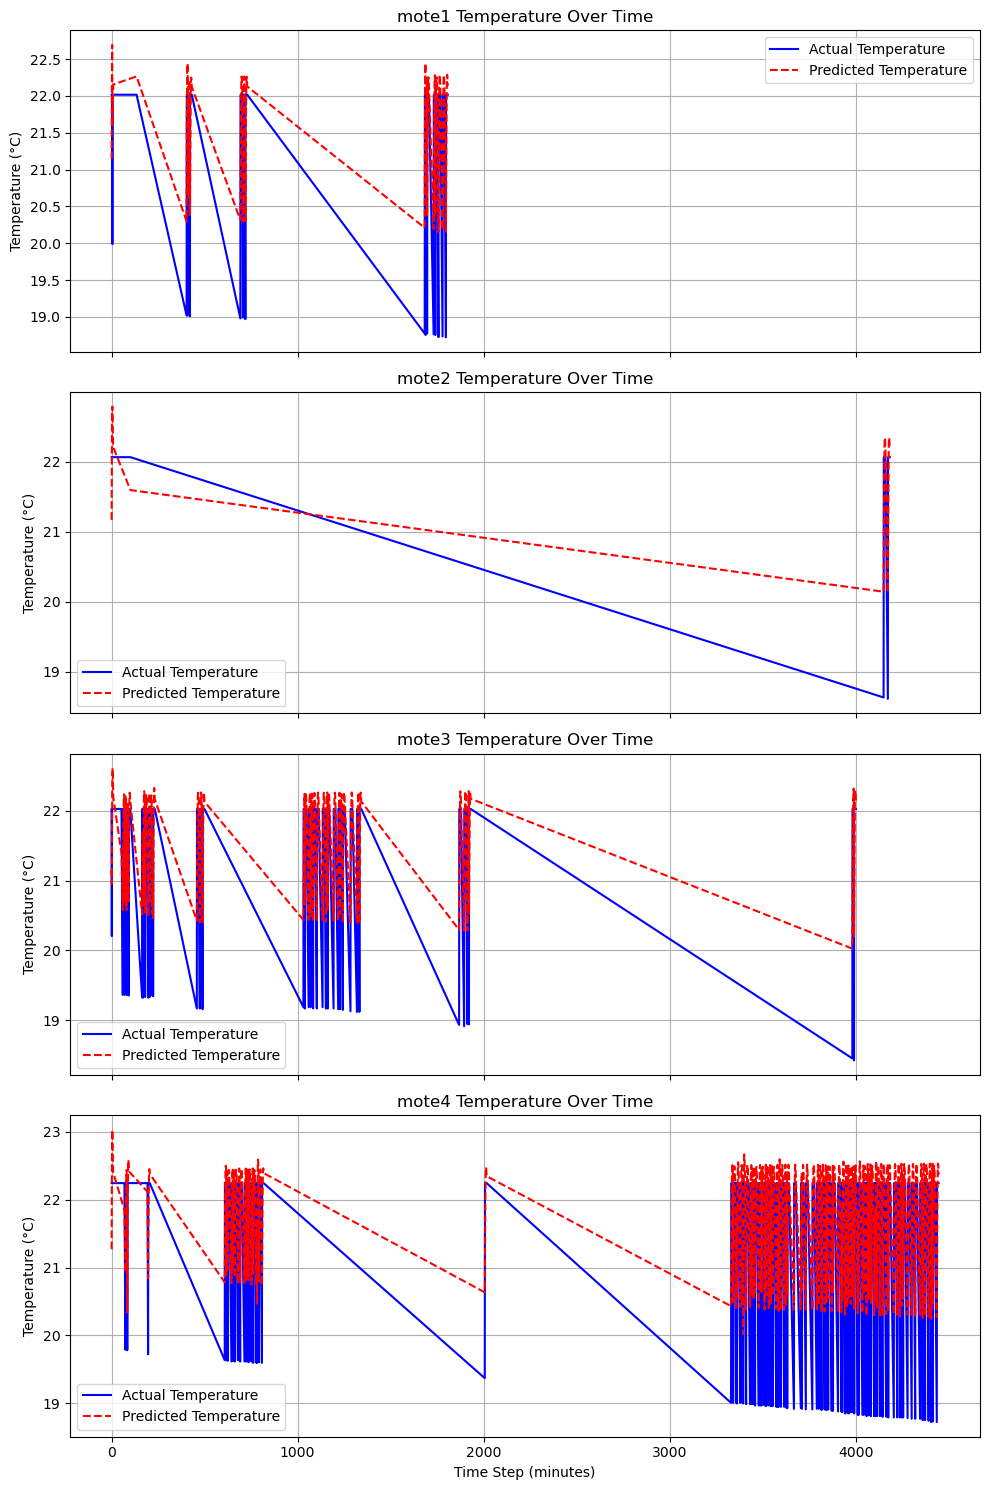

In [95]:
# Plot the actual and predicted temperatures for each mote
fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
for i, mote in enumerate(['mote1', 'mote2', 'mote3', 'mote4']):
    mote_data = valuable_sensor_df[valuable_sensor_df['selected_moteid'] == mote]
    axs[i].plot(mote_data['index'], mote_data['temperature'], 'b-', label='Actual Temperature')
    axs[i].plot(mote_data['index'], mote_data['predicted_temperature'], 'r--', label='Predicted Temperature')
    axs[i].set_title(f'{mote} Temperature Over Time')
    axs[i].set_ylabel('Temperature (°C)')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Time Step (minutes)')
plt.tight_layout()
plt.show()